# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Select group first

In [1]:
group_under_analysis = 'legacy'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Read the data

In [2]:
from nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)
# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']
# Filter out rows that added the safetensors files (ie., change_status = '+')
df_safetensors = df_safetensors[df_safetensors['change_status'] == '+']
df_safetensors
# minimum date
(df_safetensors['date'].min(),
 df_safetensors['date'].max(),
 df_safetensors['elapsed_days'].min(),
 df_safetensors['elapsed_days'].max())

100%|██████████| 51900/51900 [00:04<00:00, 12397.01commit/s]


(Timestamp('2022-09-29 11:21:48'), Timestamp('2024-12-30 11:22:26'), 6, 829)

## Analysis 4: Number of adoptions as heatmap

### Prepare the data

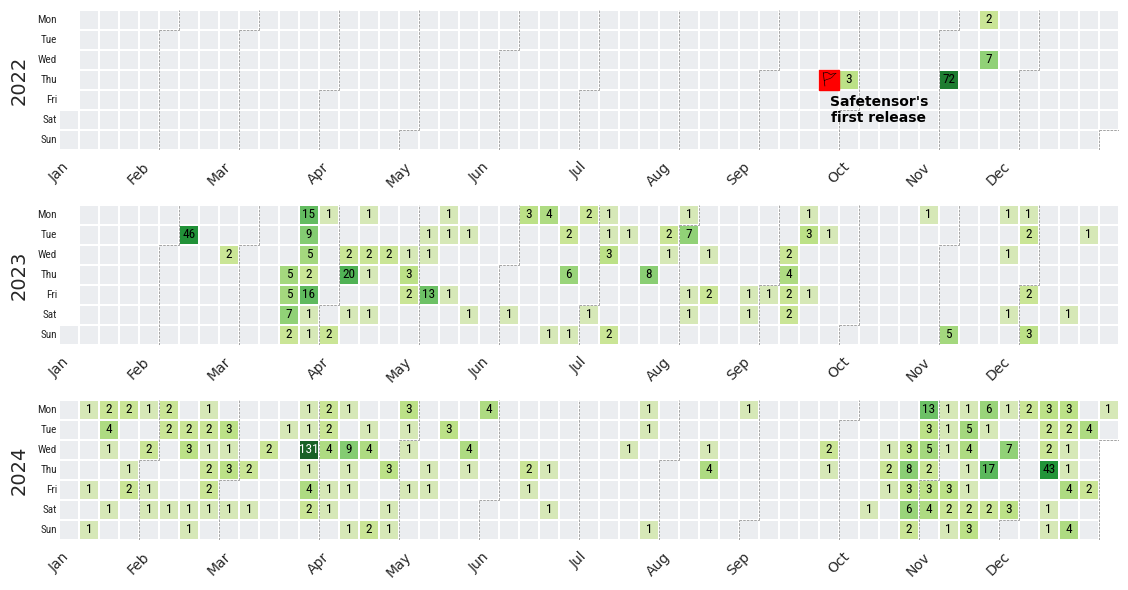

In [29]:
import datetime
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import calendar
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR, ROBOTO_CONDENSED_FONT, EMOJI_FONT
from nb_utils import get_commit_counts_by_date
from nb_utils import compute_calendar_mask
from nb_utils import compute_calendar_week
from nb_utils import compute_year_range
from matplotlib.axes import Axes
# Warnings are very unnecessary. They can only do harm  🎶
# Enjoy the silence :)
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


def overlay_white_boxes(ax, mask):
    """Draw white boxes over masked (invalid) cells."""
    n_rows, n_cols = mask.shape
    for row in range(n_rows):
        for col in range(n_cols):
            if mask[row, col]:
                # Draw a white square at (col, row)
                rect = Rectangle((col, row), 1, 1, linewidth=0, edgecolor='none', facecolor='white')
                ax.add_patch(rect)


def plot_end_of_month_lines(ax, row: int, col: int) -> None:
    # if it is the last day of the month, then add a dashed line around it to mark  end of the month
    y_boundary = (6 - row) * (1 / 7)
    ax.axvline(x=col + 1, ymin=y_boundary, ymax=1, color='gray', linestyle='--', linewidth=0.5)
    if row != 6:
        ax.hlines(row + 1, col, col + 1, color='gray', linestyle='--', linewidth=0.5)
        ax.axvline(x=col, ymin=0, ymax=y_boundary, color='gray', linestyle='--', linewidth=0.5)


def plot_year_heatmap(year: int, ax: Axes, include_dates: bool = False, include_month_markers: bool = False) -> None:
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]  # log-based counts
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts 

    # reindex the data to ensure all days of the year are present (filling missing days with 0)
    year_data = year_data.reindex(compute_year_range(year), fill_value=0)
    year_data_original = year_data_original.reindex(compute_year_range(year), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix, year_matrix_original = np.zeros((7, 53)), np.zeros((7, 53))
    for i, (date, value) in enumerate(year_data.items()):
        if date.year == year:  # skip dates from other years           
            week = compute_calendar_week(date)
            day = date.weekday()
            year_matrix[day, week] = value
            year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation
            # check if it is last day of month
            if date.month != (date + datetime.timedelta(days=1)).month and include_month_markers:
                plot_end_of_month_lines(ax, day, week)

    # Plot the heatmap with log-transformed data
    mask = compute_calendar_mask(year_matrix, year)
    year_matrix_masked = year_matrix.copy()
    year_matrix_masked[mask] = np.nan
    overlay_white_boxes(ax, mask)
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False, vmin=0, vmax=vmax_log, linewidths=0.01, linecolor='white',
                square=True, yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                mask=mask)

    # offset based on what weekday the year starts
    offset = datetime.date(year, 1, 1).weekday()
    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, fontproperties=ROBOTO_CONDENSED_FONT,
                        color='black' if year_matrix_original[row, col] < 0.9 * vmax else 'white')
            elif include_dates:  # add the month day 
                curr_date = datetime.date(year, 1, 1) + datetime.timedelta(days=(col * 7 + row - offset))
                ax.text(col + 0.5, row + 0.5, f"{curr_date.day}", ha='center', va='bottom',
                        fontsize=6, color='black', fontproperties=ROBOTO_CONDENSED_FONT)

    # Set title and adjust labels for horizontal orientation
    # ax.set_title(f"{year}")
    # Add a custom title to the left of the y-axis
    ax.text(-1.5, 3.5, f"{year}", fontsize=14, rotation=90, va='center', ha='right', transform=ax.transData)

    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(ROBOTO_CONDENSED_FONT)
        label.set_fontsize(8)
        label.set_verticalalignment('center')  # make label as close as possible to chart

    # Adjust the month labels along the x-axis
    ax.set_xticks([0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47])
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)

    if year == 2022:
        # Define the day (Thursday) and week position to highlight
        highlight_day, highlight_week = 3, 38
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release",
                ha='center', va='center', color="black", fontsize=10, weight='bold')
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩",
                fontproperties=EMOJI_FONT, ha='center', va='center', fontsize=10, color='black')


# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans'

# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed

# Get commit counts by date
commits_by_date, log_commits_by_date, vmax, vmax_log = get_commit_counts_by_date(df_safetensors)
# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(15, 6))
for i, year in enumerate(years):
    plot_year_heatmap(year, axes[i], include_month_markers=True, include_dates=False)

# Save the figure
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'{group_under_analysis}_RQ1Heatmap.pdf', bbox_inches='tight', format='pdf')
plt.show()
